# Visualising Gaussian Embeddings
Notebook for visualising examples of words embedded as gaussian distributions.

Note: assuming spherical covariance matrices for the moment.

In [1]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

**We visualise a single gaussian first**

Adapted from [a scipython blog](https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/)

In [6]:
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.

    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

def plot_gaussian_2d_relief(mu,sigma,N=240,z_lim=2,plots_margin=0.85,x_lim=(-3,3),y_lim=(-3,3),fig_size=(9,9)):
    # mu - type: numpy array, corresponds to the centre (after dimensionality reduction)
    # sigma - type: float, the value that goesin the diagonal of the covariance matrix
    # N - type: int, order of the grid. A higher N -> finer grid
    # z_lim - type: float, superior limit of the relief
    # plots_margin 
    # x_lim and y_lim - type: tuple, define the 2d margins
    
    # Our 2-dimensional distribution will be over variables X and Y
    X = np.linspace(-2.5, 2.5, N)
    Y = np.linspace(-2.5, 2.5, N)
    X, Y = np.meshgrid(X, Y)
    # Pack X and Y into a single 3-dimensional array
    pos = np.empty(X.shape + (2,))
    pos[:, :, 0] = X
    pos[:, :, 1] = Y
    
    #Computing covariance matrix. Reminder: it is assumed spherical
    Sigma = sigma*np.array([[ 1. , 0.], [0.,  1.]])
    
    # The distribution on the variables X, Y packed into pos.
    Z = multivariate_gaussian(pos, mu, Sigma)
    
    # Create a surface plot and projected filled contour plot under it.
    fig = plt.figure(figsize=fig_size)
    ax = fig.gca(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=3, cstride=3, linewidth=1, antialiased=True, cmap=cm.viridis)

    cset = ax.contourf(X, Y, Z, zdir='z', offset=-1*plots_margin, cmap=cm.viridis)
    
    # Adjust the limits, ticks and view angle
    ax.set_zlim(-0.05-plots_margin,z_lim)
    ax.set_zticks(np.linspace(0,z_lim,9))
    ax.view_init(14, -21)

    plt.show()

<IPython.core.display.Javascript object>


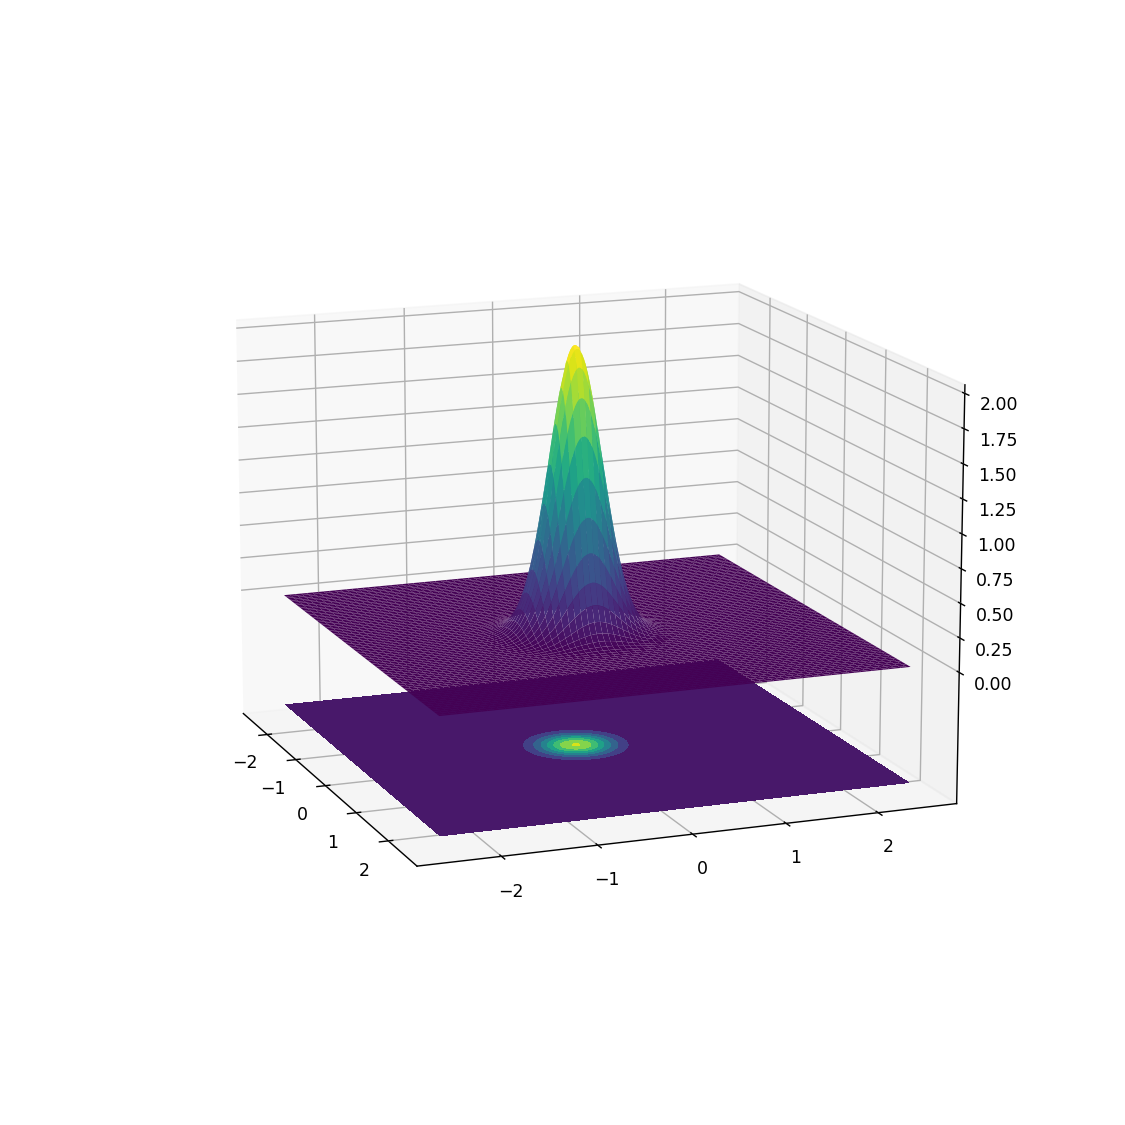

In [7]:
#example
word1_centre = np.array([0.03,-0.15])
word1_var = 0.075
plot_gaussian_2d_relief(word1_centre,word1_var)